# Synthetic TV Image Generation

## Synthetic Raw Comparisons

Compare visual similaries between real and synthetic ring generator

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from pathlib import Path
import h5py
import pickle
from tqdm.notebook import tqdm
import cv2
# import diplib as dip
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
file_name = '../../cam_geo/s_outs_v3_limited.h5'
with h5py.File(file_name, 'r') as f:
    print(list(f.keys()))
    synthetic_images = f['image'][:]
    
# file_name_2 = 'outputs/hdf5/x_outer_radiation.hdf5'
file_name_2 = '../../outputs/hdf5/x_outer_radiation.hdf5'
with h5py.File(file_name_2, 'r') as f:
    print(list(f.keys()))
    points = f['points'][:]
    tv_images = f['tv_images'][:]
    
tv_images = tv_images / 255
for i in range(len(tv_images)):
    tv_images[i] = cv2.flip(tv_images[i], 0)

['image', 'image_size', 'inver_R', 'inver_Z', 'inver_size']
['intensity', 'points', 'tv_images']


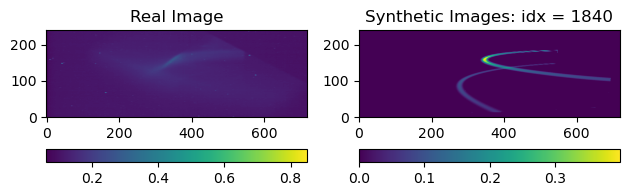

In [6]:
idx = 1840
# TV Images
plt.subplot(2, 2, 1)
plt.imshow(tv_images[idx], origin='lower')
plt.colorbar(orientation='horizontal', ax=plt.gca())
plt.title('Real Image')

# Synthetic Images
plt.subplot(2, 2, 2)
plt.imshow(synthetic_images[idx], origin='lower')
plt.colorbar(orientation='horizontal', ax=plt.gca())
plt.title(f'Synthetic Images: idx = {idx}')

plt.tight_layout()
plt.show()

In [ ]:
kernel_size = 5
sigma = 0.1
threshold = .1
erode_kernel = 1

process_tv_image =  process_image(tv_images[idx], kernel_size, sigma, threshold, erode_kernel)
plt.imshow(process_tv_image, origin='lower')
plt.show()
test = (tv_images - synthetic_images[idx]) * np.array(synthetic_images[idx])
plt.imshow(test[idx], origin='lower')
plt.title('Multiplication of Synthetic and Real Images for idx = {idx}')
plt.show()
test_scalar = np.sqrt(np.sum(test**2, axis=(1,2)))
print(test_scalar)
plt.plot(test_scalar)
plt.axvline(x=idx, color='red', linestyle='--')
plt.title('Most likely indicies (by RMS)')
print(np.argmax(test_scalar))
print(test_scalar[idx])

## Inverted to Synthetic

Samples each point from the an inverted frame and generating a ring using cam_geo, attempting to recreate TangTV vid

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import cam_geo.fake_camera_raw_lite as cg
from utils.get_file import GetTV

In [ ]:
tv = GetTV('./tv_images/l-mode')
files = tv.list_files()
for idx, file in enumerate(files):
    print(idx,"|", file)

In [ ]:
file_idx = 5
idx = 110

inverted = tv.load(files[file_idx], 'inverted')[idx]
frame = tv.load(files[file_idx], 'frames')[idx]
vid = tv.load(files[file_idx], 'vid')[int(frame)]
r_arr = tv.load(files[0], 'radii')[0]
z_arr = tv.load(files[0], 'elevation')[0]

In [ ]:
threshold = 0.2

r_coords, z_coords = np.where(inverted > threshold)
r_loc = r_arr[r_coords]
z_loc = z_arr[z_coords]
intensity = inverted[r_coords, z_coords]
test_arr = np.zeros_like(inverted)
test_intensity = np.zeros_like(inverted)
test_intensity[r_coords, z_coords] = intensity

In [ ]:
mode = 'L-mode'
skipnum = 5
choose_idx = 20

fig, ax = plt.subplots(1, 2)

r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
# Plot on the first subplot
ax[0].imshow(inverted, origin='lower')
ax[0].set_title('Inverted')
# ax[0].scatter(z_2[choose_idx], r_2[choose_idx], s = 0.5, c = 'red')

# Plot on the second subplot
ax[1].imshow(inverted, origin='lower')
ax[1].scatter(z_2,r_2, s = 1, c = 'red')
ax[1].set_title('Sampled Points')

plt.tight_layout()

plt.show()


In [ ]:
def make_samples(skipnum):
    r_coords, z_coords = np.where(inverted > .1)
    if skipnum == 0:
        r_2 = [r_coords[i] for i in range(len(r_coords))]
        z_2 = [z_coords[i] for i in range(len(r_coords))]
    elif skipnum > 0:
        r_2 = [r_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
        z_2 = [z_coords[i * skipnum] for i in range(len(r_coords) // skipnum)]
    else:
        assert('skipnum must be a positive integer')
        
    r_loc = r_arr[r_2]
    z_loc = z_arr[z_2]
    intensity = inverted[r_coords, z_coords]
    
    R0s = np.array([r_loc])
    Z0s = np.array([z_loc])
    
    nsample = Z0s.shape[0]
    
    A0s = np.array([intensity])
    M0s = np.ones((nsample,len(intensity))) * 0.001
    
    return R0s, Z0s, A0s, M0s, nsample

def make_setup(skip_num = 0):

    save_name= 'synthetic_outers.h5'
    chunk_size = 200
    
    Rinfo = {}
    Rinfo['outfile'], Rinfo['chunk_size'] = save_name, chunk_size
    Rinfo['R0s'], Rinfo['Z0s'], Rinfo['A0s'], Rinfo['M0s'], Rinfo['nsample'] = make_samples(skipnum)

    if Rinfo['nsample'] < Rinfo['chunk_size']:
        Rinfo['chunk_size'] = Rinfo['nsample']
    
    return Rinfo

In [ ]:
# Main runs
Rinfo  = make_setup()
camgeo = cg._load_camera(camera_save='cam_geo/Camera_geo.pl',
                        filename1='cam_geo/geom_240perp_unwarp_2022fwd.sav',
                        filename2='cam_geo/cam240perp_geometry_2022.sav')

# Output of rnd
output = {};
output['image_size']= camgeo['tar_x'].shape

# Inversed image  dimension
output['inver_size']= camgeo['inv_x'].shape    
output['inver_R']   = np.asarray(camgeo['inv_x'])
output['inver_Z']   = np.asarray(camgeo['inv_y'])

In [ ]:
image = cg._integrate_image(Rinfo, 0, camgeo=camgeo)

In [ ]:
fig, ax = plt.subplots(2,1)
plt.suptitle(mode)
ax[0].imshow(vid)
ax[0].set_title('Real')
ax[1].imshow(cv2.convertScaleAbs(np.flip(image * 255, 0), alpha= 1.5, beta = 2))
ax[1].set_title('Synthetic')
plt.tight_layout()
plt.show()